In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths,gauss_noise=False,gauss_blur=None,resize=128,p=0.5, center_crop=False, transform=None):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def add_gaussian_noise(self, image):
        #สร้าง gaussian noise
        x, y, channel = image.shape
        mean = random.uniform(-50, 50)
        gaussian_noise = np.random.normal(loc=mean,scale=100,size=(x,y,channel)).astype(np.float32)
        #ภาพ ผสมกับ Gaussian Noise
        noisy_image = image + gaussian_noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    def do_gaussian_blur(self, image):
        kernel_size = random.randrange(3, 12, 2)
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0) #ภาพ,Kernel Size, Standard Deviation
    
    def do_center_crop(self, image, desire_h=128, desire_w=128):
        height,width, _ = image.shape
        if width <= height: #กรณี width สั้น ให้ resize โดยยึด width 
            #ปรับ width เทียบเท่าแล้ว เหลือ Height ที่ยังเกิน
            #เพื่อให้สัดส่วนคงเดิม ไม่ถูกบีบ ให้หาอัตราส่วนภาพ
            img_ratio = height / width
            image = cv2.resize(image, (self.resize, int(self.resize*img_ratio))) #image , (width, height) ที่จะไป
            #พอ resize แล้ว จะได้ width height ตัวใหม่ 
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[new_resize_h//2 - self.resize//2: new_resize_h//2 + self.resize//2, 0:self.resize]
        else:
            #ปรับ Height เทียบเท่าแล้ว เหลือ width ที่ยังเกิน
            img_ratio = width / height
            image = cv2.resize(image, (int(self.resize*img_ratio), self.resize))
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[0:self.resize, new_resize_w//2 - self.resize//2: new_resize_w//2 + self.resize//2]
        return crop_img

    def __getitem__(self, idx):
        image_paths = self.image_paths[idx]
        if not os.path.exists(image_paths):
            print(f"File {image_paths} not found, skipping.")
            return torch.zeros((3, self.resize, self.resize)), 0  # Handle this case in the training loop
        img = plt.imread(image_paths)
        if img.ndim == 2: #ถ้าเป็น Gray --> บังคับเป็น RGB Format
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        #ถ้าทำ center crop ก็ไม่ต้องทำ Resize, เลือกอย่างใดอย่างนึง
        if(self.center_crop):
            gt_image = self.do_center_crop(img, desire_h=self.resize, desire_w=self.resize)
            # print("*******")
            # print(gt_image.shape)
        else:
            gt_image = cv2.resize(img, (self.resize, self.resize))  #Ground truth image
        image = gt_image.copy()

    # Ensure minimum size of 7x7
        if image.shape[0] < 7 or image.shape[1] < 7:
            image = cv2.resize(image, (max(7, image.shape[1]), max(7, image.shape[0])))
        if gt_image.shape[0] < 7 or gt_image.shape[1] < 7:
            gt_image = cv2.resize(gt_image, (max(7, gt_image.shape[1]), max(7, gt_image.shape[0])))
            
            
        #ใส่ความน่าจะเป็น ที่จะถูก Apply G-noise, G-blur
        if self.p >= 0.5:
            if self.gauss_noise:
                image = self.add_gaussian_noise(image)
            if self.gauss_blur:
                image = self.do_gaussian_blur(image)
        # print("===================")
        # print(f"Image shape: {image.shape}")
        if self.transform:
            image = self.transform(image)
            gt_image = self.transform(gt_image)
        # Print shapes for debugging
        # print(f"Image shape: {image.shape}")
        # print(f"GT image shape: {gt_image.shape}")
        return image, gt_image
### END CODE HERE ###

In [3]:
### START CODE HERE ###
data_dir = r"D:\KMITL\4D\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\data\img_align_celeba"
image_paths = []
for file_name in os.listdir(data_dir):
    image_paths.append(f"{data_dir}/{file_name}")
print(image_paths)

transform = transforms.Compose([transforms.ToTensor()])

dataset = CustomImageDataset(image_paths=image_paths,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             p=0.5,
                             center_crop=True,
                             transform=transform
                            )
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

transform = transforms.Compose([transforms.ToTensor()])
train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
train_dataset = CustomImageDataset(image_paths=train_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
test_dataset = CustomImageDataset(image_paths=test_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

train_batch, train_gt = next(iter(trainloader)) 
test_batch, test_gt = next(iter(testloader)) 

### END CODE HERE ###

['D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000001.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000002.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000003.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000004.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000005.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000006.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000007.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000008.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-main\\data\\img_align_celeba/000009.jpg', 'D:\\KMITL\\4D\\Lab-6-Transfer-Learning-Hyperparameter-Tuning-m

In [4]:
batch,gt_img = next(iter(dataloader)) 
print(batch.shape)
print(gt_img.shape)
# print(len(batch))
torch.is_tensor(batch)

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


True

In [5]:
train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
train_dataset = CustomImageDataset(image_paths=train_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
test_dataset = CustomImageDataset(image_paths=test_files,
                            gauss_noise=True,
                            gauss_blur=True,
                            resize=128,
                            p=0.5,
                            center_crop=True,
                            transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
batch,gt_img = next(iter(trainloader)) 
print(batch.shape)
print(gt_img.shape)
# print(len(batch))
torch.is_tensor(batch)


torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


True

In [6]:
# Verify dataset output shapes
train_batch, train_gt = next(iter(trainloader))
test_batch, test_gt = next(iter(testloader)) 

print(f"Train batch shape: {train_batch.shape}")
print(f"Train GT batch shape: {train_gt.shape}")
print(f"Test batch shape: {test_batch.shape}")
print(f"Test GT batch shape: {test_gt.shape}")

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = Autoencoder(architecture)  # Ensure the model architecture is consistent
# model = model.to(device)
# loss_fn = nn.MSELoss()

# if optimizer == 'Adam':
#     opt = torch.optim.Adam(model.parameters(), lr=lr)
# elif optimizer == 'SGD':
#     opt = torch.optim.SGD(model.parameters(), lr=lr)
    
# for epoch in range(num_epochs):
#     model.train()
avg_train_loss = 0
avg_test_loss = 0
# for batch in trainloader:
#     images, train_gt_img = batch  # unpack the batch
#     print(images.shape, train_gt_img.shape)

Train batch shape: torch.Size([16, 3, 128, 128])
Train GT batch shape: torch.Size([16, 3, 128, 128])
Test batch shape: torch.Size([16, 3, 128, 128])
Test GT batch shape: torch.Size([16, 3, 128, 128])


torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


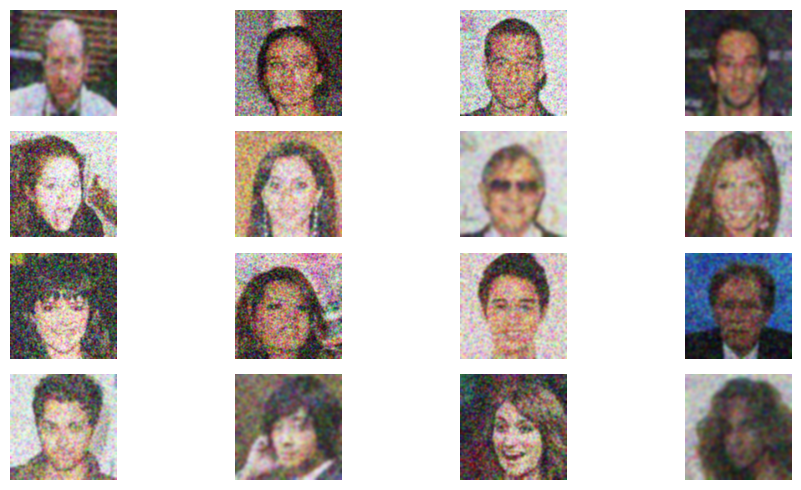

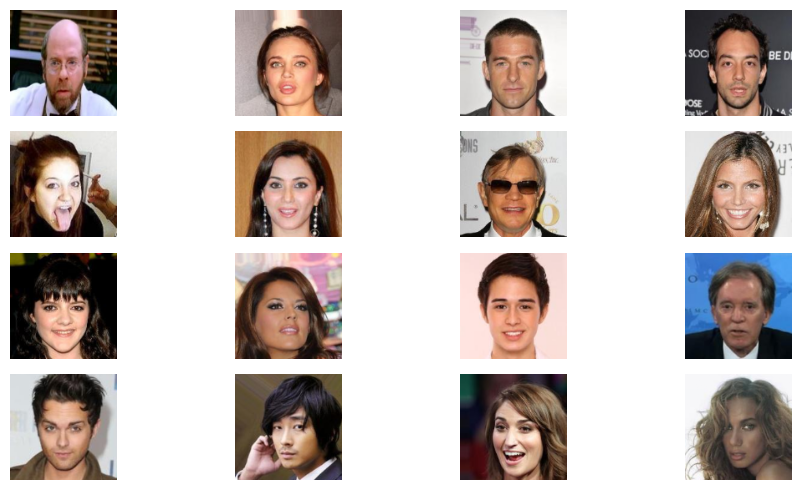

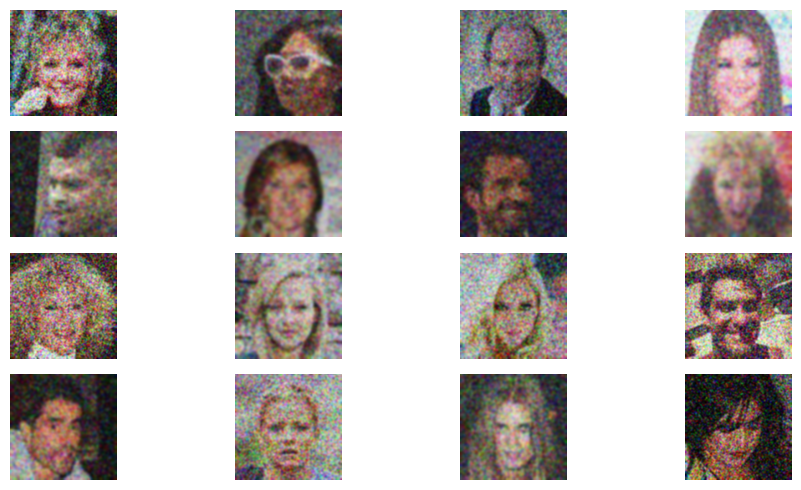

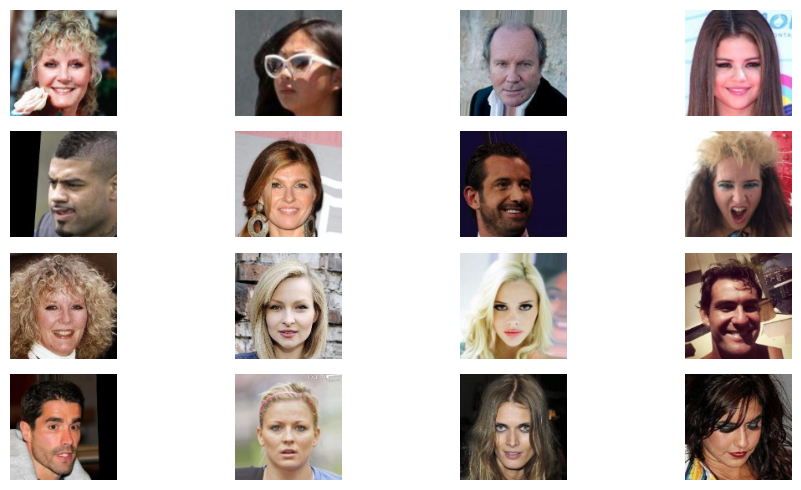

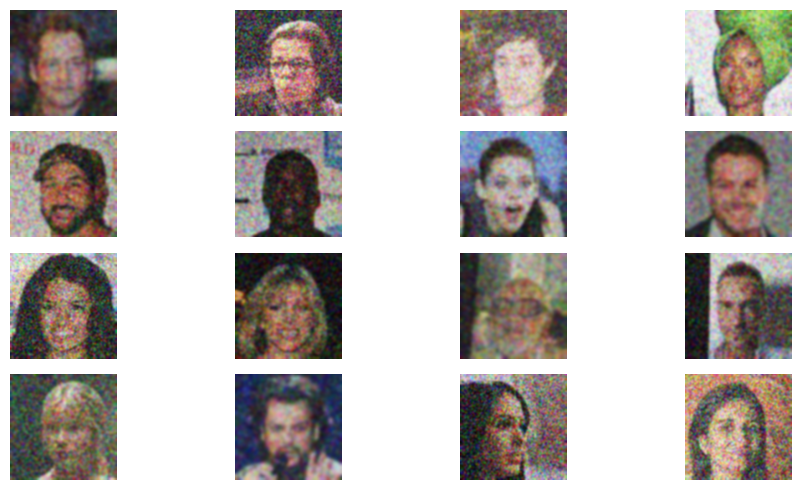

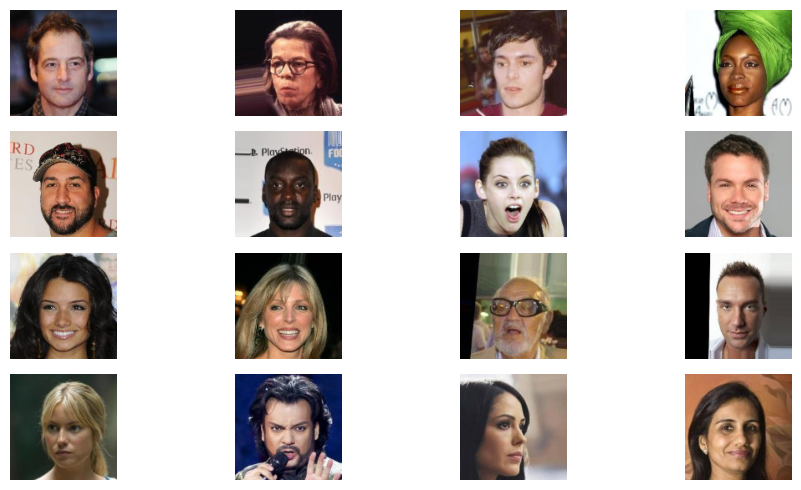

In [7]:
### START CODE HERE ###
def imshow_grid(images):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    # print(grid_size)
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i])
        a.axis("off")
    plt.tight_layout()
    plt.show()

def imshow_grid(images):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = np.transpose(images[i], (1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        a.axis("off")
    
    plt.tight_layout()
    plt.show()



print(train_batch.shape)
print(train_gt.shape)
print(test_batch.shape)
print(test_gt.shape)
imshow_grid(batch.numpy())
imshow_grid(gt_img.numpy())
imshow_grid(train_batch.numpy())
imshow_grid(train_gt.numpy())
imshow_grid(test_batch.numpy())
imshow_grid(test_gt.numpy())
### END CODE HERE ###

In [8]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, architecture):
        super(Autoencoder, self).__init__()
        self.architecture = architecture
        #Encoder
        
        if len(self.architecture)  == 3:
            # print("this is 3")
            # print(self.architecture[0])
            self.conv_in = nn.Conv2d(3, self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.down1 = DownSamplingBlock(self.architecture[0], self.architecture[1], kernel_size=3, stride=1, padding=1)
            ### DESIGN YOUR OWN MODEL ###
            self.down2 = DownSamplingBlock(self.architecture[1], self.architecture[2], kernel_size=3, stride=1, padding=1)
            #Decoder
            self.up3 = UpSamplingBlock(self.architecture[2], self.architecture[1], kernel_size=3, stride=1, padding=1)
            self.up4 = UpSamplingBlock(self.architecture[1], self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.conv = nn.Conv2d(self.architecture[0], 3, kernel_size=3, stride=1, padding=1)
        elif len(self.architecture)  == 4:
            # print("this is 4")
            self.conv_in = nn.Conv2d(3, self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.down1 = DownSamplingBlock(self.architecture[0], self.architecture[1], kernel_size=3, stride=1, padding=1)
            ### DESIGN YOUR OWN MODEL ###
            self.down2 = DownSamplingBlock(self.architecture[1], self.architecture[2], kernel_size=3, stride=1, padding=1)
            self.down3 = DownSamplingBlock(self.architecture[2], self.architecture[3], kernel_size=3, stride=1, padding=1)
            #Decoder
            self.up4 = UpSamplingBlock(self.architecture[3], self.architecture[2], kernel_size=3, stride=1, padding=1)
            self.up5 = UpSamplingBlock(self.architecture[2], self.architecture[1], kernel_size=3, stride=1, padding=1)
            self.up6 = UpSamplingBlock(self.architecture[1], self.architecture[0], kernel_size=3, stride=1, padding=1)
            self.conv = nn.Conv2d(self.architecture[0], 3, kernel_size=3, stride=1, padding=1)
    #     self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    #     self.down1 = DownSamplingBlock(64, 128, kernel_size=3, stride=1, padding=1)
    #     ### DESIGN YOUR OWN MODEL ###
    #     self.down2 = DownSamplingBlock(128, 256, kernel_size=3, stride=1, padding=1)
    #     #Decoder
    #     self.up3 = UpSamplingBlock(256, 128, kernel_size=3, stride=1, padding=1)
    #     self.up4 = UpSamplingBlock(128, 64, kernel_size=3, stride=1, padding=1)
    #     self.conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        if len(self.architecture)  == 3:
            x = self.conv_in(x)
            x = self.down1(x)
            x = self.down2(x)
            
            x = self.up3(x)
            x = self.up4(x)
            x = self.conv(x)
        if len(self.architecture)  == 4:
            x = self.conv_in(x)
            x = self.down1(x)
            x = self.down2(x)
            x = self.down3(x)
            
            x = self.up4(x)
            x = self.up5(x)
            x = self.up6(x)
            x = self.conv(x)
        print(f"Model output shape: {x.shape}")
        return x
### END CODE HERE ###

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [9]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

ray.shutdown()
ray.init(num_gpus=1, ignore_reinit_error=True)

def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

def train_model(config):
    # Extract hyperparameters from config
    architecture = config["architecture"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    num_epochs = config["num_epochs"]
    optimizer = config["optimizer"]
    
    # Transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Split data
    train_files, test_files = train_test_split(image_paths, test_size=0.2, random_state=42)
    train_dataset = CustomImageDataset(image_paths=train_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5,
                                center_crop=True,
                                transform=transform)
    test_dataset = CustomImageDataset(image_paths=test_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5,
                                center_crop=True,
                                transform=transform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Verify dataset output shapes
    train_batch, train_gt = next(iter(trainloader))
    test_batch, test_gt = next(iter(testloader)) 

    print(f"Train batch shape: {train_batch.shape}")
    print(f"Train GT batch shape: {train_gt.shape}")
    print(f"Test batch shape: {test_batch.shape}")
    print(f"Test GT batch shape: {test_gt.shape}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Autoencoder(architecture)  # Ensure the model architecture is consistent
    model = model.to(device)
    loss_fn = nn.MSELoss()
    
    if optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=lr)
        
    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_test_loss = 0
        for batch in trainloader:
            images, train_gt_img = batch  # unpack the batch
            
            # Print shapes for debugging
            print(f"Training image shape: {images.shape}")
            print(f"Training GT image shape: {train_gt_img.shape}")

            # Move data to the device
            images = images.to(device)
            train_gt_img = train_gt_img.to(device)
            
            # Forward pass
            output = model(images)
            
            # Print model output shape for debugging
            print(f"Model output shape: {output.shape}")
            
            # Compute the loss
            loss = loss_fn(output, train_gt_img)
            
            # Backpropagation and optimization step
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Track the training loss
            avg_train_loss += loss.item()
            
        avg_train_loss /= len(trainloader)
        
        total_psnr = 0
        total_ssim = 0
        model.eval()
        with torch.no_grad():
            for batch in testloader:
                images, test_gt_img = batch  # Unpack test batch
                
                # Print shapes for debugging
                print(f"Testing image shape: {images.shape}")
                print(f"Testing GT image shape: {test_gt_img.shape}")
                
                # Move data to the device
                images = images.to(device)
                test_gt_img = test_gt_img.to(device)
                
                # Forward pass
                output = model(images)
                
                # Compute the loss for test data
                loss = loss_fn(output, test_gt_img)
                avg_test_loss += loss.item()
                
                # Convert tensors to numpy arrays for PSNR and SSIM calculations
                output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
                images_np = test_gt_img.cpu().numpy().transpose(0, 2, 3, 1)
                
                # Calculate PSNR and SSIM for each image in the batch
                for i in range(batch_size):
                    img = images_np[i]
                    rec_img = output_np[i]
                    total_psnr += psnr(img, rec_img, data_range=1.0)
                    total_ssim += ssim(img, rec_img, data_range=1.0, multichannel=True)
        
        # Average the PSNR, SSIM, and loss over the test dataset
        avg_psnr = total_psnr / (len(testloader) * batch_size)
        avg_ssim = total_ssim / (len(testloader) * batch_size)
        avg_test_loss /= len(testloader)
        
        # Report results to Ray Tune
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_test_loss,
            "val_psnr": avg_psnr,
            "val_ssim": avg_ssim,
        })

# config = {
#     'architecture': tune.choice([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
#     "lr": tune.grid_search([1e-3, 1e-4, 1e-2]),
#     "batch_size": tune.grid_search([16, 32]),
#     "num_epochs": tune.grid_search([1, 2, 3]),
#     'optimizer': tune.choice(['Adam', 'SGD']),
# }
config = {
    'architecture': tune.choice([[32, 64, 128]]),
    "lr": tune.grid_search([1e-3]),
    "batch_size": tune.grid_search([16]),
    "num_epochs": tune.grid_search([1]),
    'optimizer': tune.choice(['Adam', 'SGD']),
}

tune.run(
    train_model,
    config=config,
    num_samples=2,  # Number of trials
    trial_dirname_creator=short_dirname,
)


2024-09-17 14:09:26,083	INFO worker.py:1786 -- Started a local Ray instance.
2024-09-17 14:09:27,892	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=22636) Train batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Train GT batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Test batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Test GT batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Training image shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Training GT image shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Model output shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Model output shape: torch.Size([16, 3, 128, 128])
(train_model pid=20756) Train batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=20756) Train GT batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=20756) Test batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=20756) Test GT batch shape: torch.Size([16, 3, 128, 128])
(train_model pid=22636) Training image shape: torch.Size([16, 3, 128, 128]) [repeated 6x across cluster] 

2024-09-17 14:55:11,205	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-09-17 14:55:11,225	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/sitth/ray_results/train_model_2024-09-17_14-09-27' in 0.0150s.


(train_model pid=22636) Training image shape: torch.Size([16, 3, 128, 128]) [repeated 5x across cluster]
(train_model pid=22636) Training GT image shape: torch.Size([16, 3, 128, 128]) [repeated 5x across cluster]
(train_model pid=20756) Model output shape: torch.Size([16, 3, 128, 128]) [repeated 10x across cluster]
(train_model pid=22636) Training image shape: torch.Size([16, 3, 128, 128]) [repeated 4x across cluster]
(train_model pid=22636) Training GT image shape: torch.Size([16, 3, 128, 128]) [repeated 4x across cluster]
(train_model pid=22636) Model output shape: torch.Size([16, 3, 128, 128]) [repeated 9x across cluster]


2024-09-17 14:55:21,372	INFO tune.py:1041 -- Total run time: 2753.48 seconds (2743.22 seconds for the tuning loop).
2024-09-17 14:55:21,373	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
